In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Function to preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        raise FileNotFoundError(f"PNG file {image_path} not found")

    # Normalize and resize
    img = img.astype(np.float32)
    img /= np.max(img)  # Normalize to [0, 1]
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = np.stack([img] * 3, axis=-1)  # Expand dimensions to RGB

    return img

# Function to identify features
def identify_features(image):
    if image.ndim == 3:
        image = np.mean(image, axis=-1)  # Convert to grayscale if it's RGB
    
    coronal_holes = (image < 0.1).astype(np.uint8)  # Dark regions
    solar_flares = (image > 0.4).astype(np.uint8)  # Bright regions
    active_regions = ((image >= 0.3) & (image <= 0.4)).astype(np.uint8)  # Medium brightness
    quiet_regions = ((image >= 0.15) & (image < 0.3)).astype(np.uint8)  # Quiet regions
    
    # Combine into a single mask
    features = np.stack((coronal_holes, solar_flares, active_regions, quiet_regions), axis=-1)
    return features


In [3]:
# Save mask as image file
def save_mask(mask, output_path):
    # Convert mask to a single-channel image by assigning unique values to each feature
    combined_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    combined_mask[mask[:, :, 0] == 1] = 1  # Coronal Holes
    combined_mask[mask[:, :, 1] == 1] = 2  # Solar Flares
    combined_mask[mask[:, :, 2] == 1] = 3  # Active Regions
    combined_mask[mask[:, :, 3] == 1] = 4  # Quiet Regions
    
    success = cv2.imwrite(output_path, combined_mask)
    if not success:
        print(f"Failed to save mask to {output_path}")

# Load the dataset of 100 images and save masks
def load_dataset(image_folder, mask_folder):
    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)
    
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(".png")]
    images = []
    masks = []
    for idx, image_path in enumerate(image_paths):
        try:
            print(f"Processing {image_path}")
            img = preprocess_image(image_path)
            mask = identify_features(img)
            
            images.append(img)
            masks.append(mask)
            
            # Save mask to file
            mask_filename = f"mask_{idx:03d}.png"
            mask_path = os.path.join(mask_folder, mask_filename)
            save_mask(mask, mask_path)
            
            print(f"Saved mask to {mask_path}")
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
    
    print(f"Total images processed: {len(images)}")
    return images, masks


In [4]:
# Define the paths
dataset_folder = r'C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final'  # Replace with the path to your 'dataset' folder
mask_folder = os.path.join(r'C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset', 'masks')  # 'masks' folder beside 'dataset' folder

# Load all images and masks
images, masks = load_dataset(dataset_folder, mask_folder)

# Split the dataset
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Convert to NumPy arrays for training
train_images = np.array(train_images)
val_images = np.array(val_images)
train_masks = np.array(train_masks)
val_masks = np.array(val_masks)


Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210601_000011_1024_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_000.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210601_000011_2048_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_001.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210602_000010_4096_0171.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_002.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210602_000011_1024_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_003.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\2021

In [5]:
# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder (downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck (Bridge)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    
    # Output Layer
    outputs = layers.Conv2D(4, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
# Data Augmentation (for training)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_masks, batch_size=8),
    validation_data=(val_images, val_masks),
    epochs=10,  # Adjust epochs based on your dataset size
    callbacks=[early_stopping]
)

c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.3786 - loss: 1.3075 - val_accuracy: 0.5431 - val_loss: 1.2452
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.4350 - loss: 1.2691 - val_accuracy: 0.5640 - val_loss: 1.1414
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.4516 - loss: 1.2015 - val_accuracy: 0.5967 - val_loss: 0.9380
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.3900 - loss: 2.8953 - val_accuracy: 0.5766 - val_loss: 1.0765
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.4349 - loss: 1.2262 - val_accuracy: 0.5337 - val_loss: 1.1218
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.4710 - loss: 1.1950 - val_accuracy: 0.5563 - val_loss: 1.0520
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.3857 - loss: 3.6145 - val_accuracy: 0.4631 - val_loss: 1.8538
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.3416 - loss: 729.8638 - val_accuracy: 0.3793 - val_loss: 25.4546


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


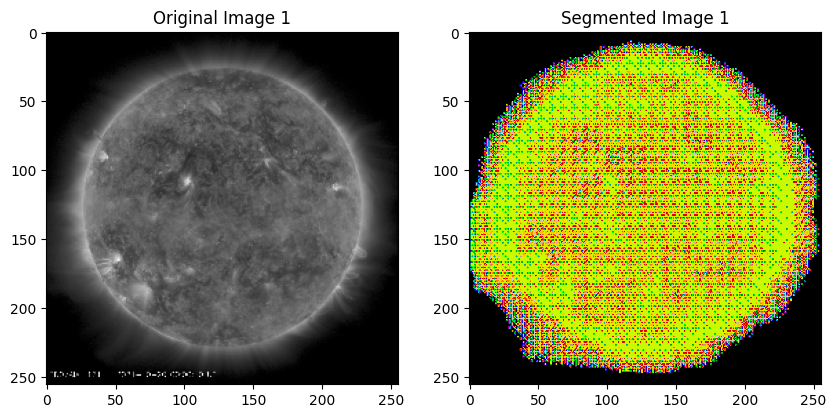

Composition of features in Image 1:
{np.int64(0): np.float64(30.4107666015625), np.int64(1): np.float64(3.80706787109375), np.int64(2): np.float64(48.8800048828125), np.int64(3): np.float64(16.90216064453125)}


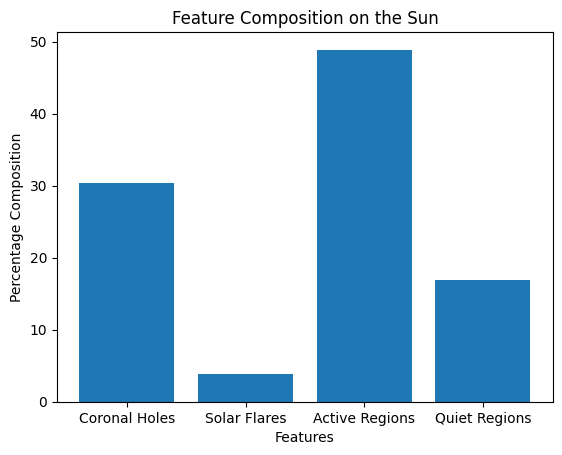

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


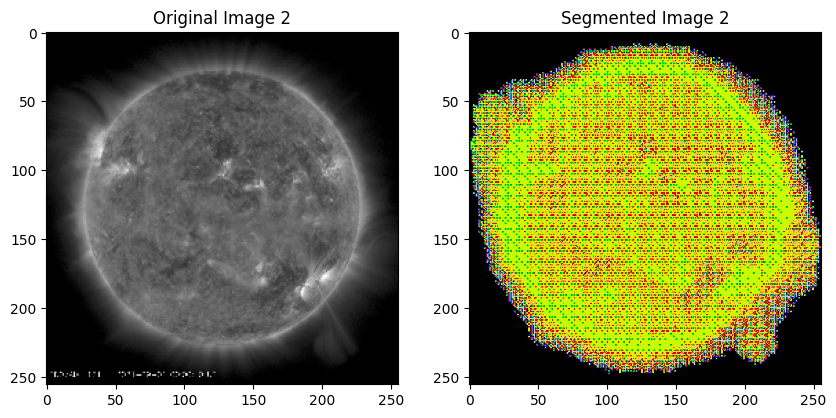

Composition of features in Image 2:
{np.int64(0): np.float64(30.60760498046875), np.int64(1): np.float64(3.83758544921875), np.int64(2): np.float64(48.5198974609375), np.int64(3): np.float64(17.034912109375)}


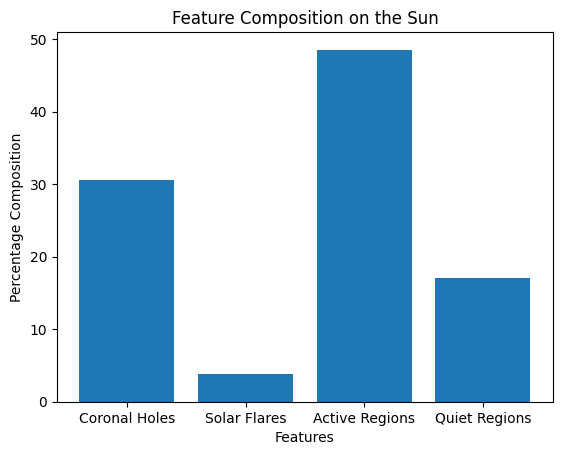

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


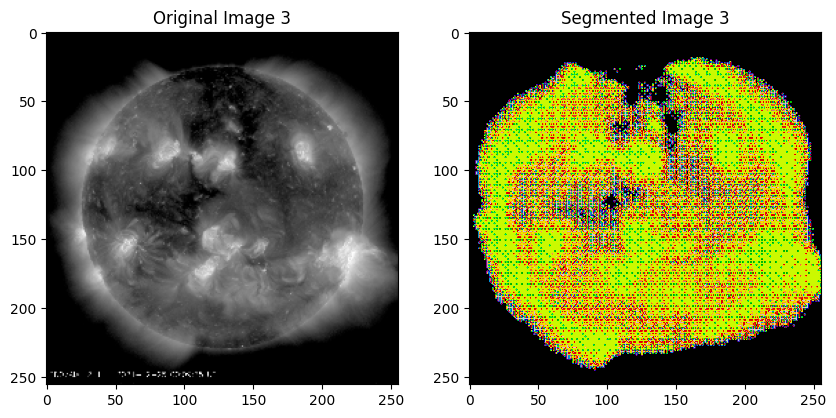

Composition of features in Image 3:
{np.int64(0): np.float64(37.3504638671875), np.int64(1): np.float64(3.23944091796875), np.int64(2): np.float64(41.30706787109375), np.int64(3): np.float64(18.10302734375)}


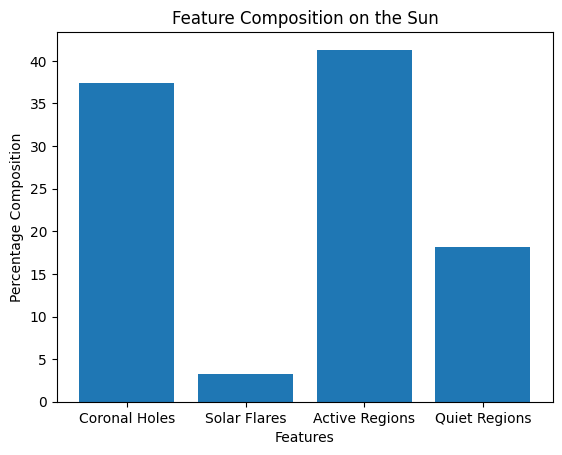

In [8]:

# Visualize the results and the composition of features
def calculate_feature_composition(segmented_image):
    unique, counts = np.unique(segmented_image, return_counts=True)
    total_pixels = segmented_image.size
    composition = dict(zip(unique, counts / total_pixels * 100))
    return composition

def plot_composition(composition):
    labels = ['Coronal Holes', 'Solar Flares', 'Active Regions', 'Quiet Regions']
    sizes = [composition.get(i, 0) for i in range(4)]
    
    plt.bar(labels, sizes)
    plt.xlabel('Features')
    plt.ylabel('Percentage Composition')
    plt.title('Feature Composition on the Sun')
    plt.show()

# Post-processing and plotting for 3 test samples
for i in range(3):  # Select 3 sample test images
    # Run the model prediction
    segmented_image = model.predict(np.expand_dims(val_images[i], axis=0))[0]
    segmented_image = np.argmax(segmented_image, axis=-1)  # Get the class with max probability for each pixel
    
    # Plot original and segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(val_images[i])
    plt.title(f'Original Image {i+1}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='nipy_spectral')
    plt.title(f'Segmented Image {i+1}')
    plt.show()
    
    # Calculate and plot the composition
    composition = calculate_feature_composition(segmented_image)
    print(f"Composition of features in Image {i+1}:")
    print(composition)
    plot_composition(composition)
